<a href="https://colab.research.google.com/github/aryaladhani/Protein-structure-segmentation/blob/main/Supertraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting the Drive to load the Dataset


In [ ]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#include the path in which the data is stored
positive_proteins_dir = "/content/drive/MyDrive/utils/positive.txt"
#include path where positive proteins are present
negative_proteins_dir = "/content/drive/MyDrive/utils/negative.txt"
#include path where negative proteins are present

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing necessary libraries

In [ ]:
import random
import numpy as np  
import torch 
import torch.nn as nn
import torch.nn.functional as F
import time 
import matplotlib.pyplot as plt

Helper functions necessary for converting .txt file to processible data

In [ ]:

def average_sequence_length(data):
  sum =0
  for i in range(len(data)):
    sum += len(data[i][1])
  return (sum//len(data))

def add_amino_acids(protein, avg):
    n = len(protein)
    x = avg - n
    protein2 = protein + x*str('A')
    return protein2

def remove_amino_acids(protein,avg):
    n = len(protein)
    x = n - avg
    protein2 = protein[x//2:x//2+avg]
    return protein2

def augment_protein_sequence(data):
    avg = 390
    for i in range (len(data)):
        if (len(data[i][1])>avg):
          data[i][1] = remove_amino_acids(data[i][1],avg)
        else:
          data[i][1] = add_amino_acids(data[i][1],avg)
    return data 

def sequence_extraction(data_dir,protein_category):
    f = open(data_dir)
    lines = f.read() 
    lines = lines.split('>')
    out = [[0 for x in range(3)] for y in range(len(lines))]
    for i in range(len(lines)):
      line= lines[i].split(' ')
      accesion_code = line[0]
      sequence = line[-1].split(']')[-1].replace('\n','')
      out[i][0] = str(accesion_code)
      out[i][1] = str(sequence).replace('Precursor','')
      out[i][1] = out[i][1].replace('C887.02','')
      if (protein_category=='positive'):
          out[i][2]=1
      else :
          out[i][2]=0
    return out[1:]

protein_set ={
    'A':0,
    'C':1,
    'D':2,
    'E':3,
    'F':4,
    'G':5,
    'H':6,
    'I':7,
    'K':8,
    'L':9,
    'M':10,
    'N':11,
    'P':12,
    'Q':13,
    'R':14,
    'S':15,
    'T':16,
    'V':17,
    'W':18,
    'Y':19
}
def get_process_data(protein_data):
  random_sequence = protein_data[0][1]
  protein_size = len(random_sequence)
  data_size = len(protein_data)
  inputs = -1*np.ones((data_size,protein_size,20))
  labels = np.zeros((data_size,1))
  for i in range(data_size):
    protein_sequence = protein_data[i][1]
    for j in range (len(protein_sequence)):
      amino_acid = protein_sequence[j]
      if (amino_acid=='B' or amino_acid=='J' or  amino_acid=='O' or amino_acid=='U' or amino_acid=='X' or amino_acid=='Z'  ):
        amino_acid ='A'
      k = protein_set[amino_acid]
      inputs[i][j][k] = 390
    labels[i][0]=protein_data[i][2]
  inputs = np.reshape(inputs, [data_size,len(protein_data[0][1])*20])
  labels = np.reshape(labels, [data_size,1])
  inputs = torch.from_numpy(inputs)
  labels = torch.from_numpy(labels)
  inputs = inputs.type(torch.FloatTensor)
  labels = labels.type(torch.FloatTensor)
  return inputs, labels 

def get_data(protein_dataset):
  dataset = augment_protein_sequence(protein_dataset)
  training_set = dataset[0:5000]
  val_set = dataset[5000:5370]
  test_set = dataset[5370:]
  training_inputs, training_labels = get_process_data(training_set)
  val_inputs, val_labels = get_process_data(val_set)
  test_inputs, test_labels = get_process_data(test_set)
  return training_inputs, training_labels, val_inputs, val_labels, test_inputs, test_labels

def getlength(data):
    sequence_length= []
    for i in range(len(data)):
        sequence_length.append(len(data[i][1]))
    return np.array(sequence_length)
# print(dataset)

Data Visualization 


In [ ]:
positive_proteins = sequence_extraction(positive_proteins_dir,'positive')
negative_proteins = sequence_extraction (negative_proteins_dir,'negative')
len_pos = getlength(positive_proteins)
len_neg = getlength(negative_proteins)
print("The number of positive classifiers in the dataset are :" + str(len(positive_proteins)))
print("The number of negative classifiers in the dataset are :" + str(len(negative_proteins)))
print(f"Average length of positive classifiers is: {average_sequence_length(positive_proteins)}")
print(f"Average length of negative classifiers is: {average_sequence_length(negative_proteins)}")

The number of positive classifiers in the dataset are :2870
The number of negative classifiers in the dataset are :76614
Average length of positive classifiers is: 226
Average length of negative classifiers is: 555


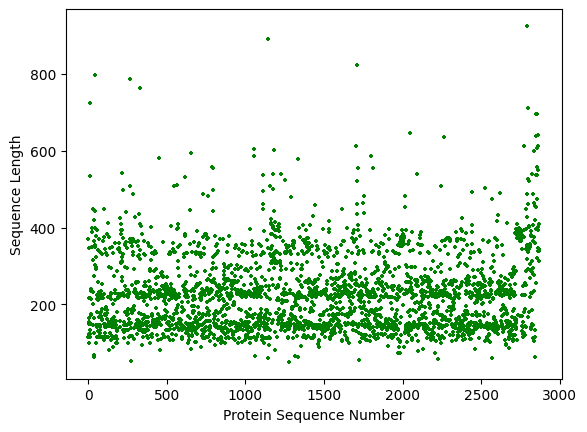

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.scatter(np.arange(0,len(len_pos),1), len_pos , color ='g', marker = '+', s= 6)
plt.xlabel("Protein Sequence Number")
plt.ylabel("Sequence Length")
plt.show()
plt.savefig('/content/drive/MyDrive/utils/positive_data_visualization.jpg')

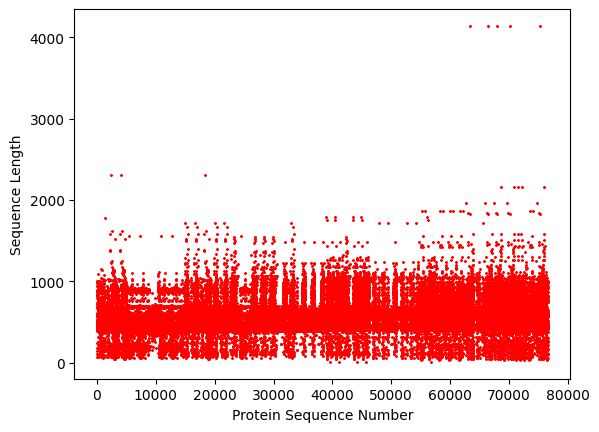

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.scatter(np.arange(0,len(len_neg),1), len_neg , color ='r', marker = 'X', s=1)
plt.xlabel("Protein Sequence Number")
plt.ylabel("Sequence Length")
plt.show()
plt.savefig('/content/drive/MyDrive/utils/negative_data_visualization.jpg')

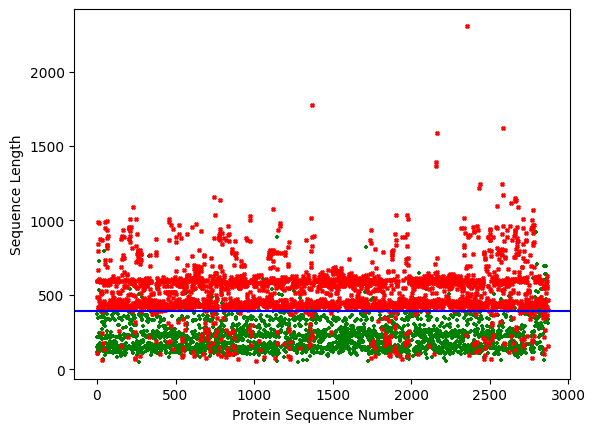

<Figure size 640x480 with 0 Axes>

In [ ]:
protein_dataset = positive_proteins + negative_proteins[0:len(positive_proteins)]
plt.scatter(np.arange(0,len(len_pos),1), len_pos , color ='g', marker = '+', s= 6)
plt.scatter(np.arange(0,len(len_pos),1), len_neg[0:len(len_pos)] , color ='r', marker = 'X', s= 6)
# plt.plot(x390)
plt.axhline(y = 390, color ='b')
plt.xlabel("Protein Sequence Number")
plt.ylabel("Sequence Length")
plt.show()
plt.savefig('/content/drive/MyDrive/utils/positve_vs_negative_data_visualization.jpg')

Data Loading

In [ ]:
augmented_sequences = augment_protein_sequence(protein_dataset)
random.shuffle(augmented_sequences)
training_inputs, training_labels, val_inputs, val_labels, test_inputs, test_labels = get_data(augmented_sequences)

Data Analysis is complete now. Proceeding towards model building

Model Architecture - 5 Layers(7560-1000-400-100-20-1) 
loss used = Binary Cross Entropy

In [ ]:
class nnModel(nn.Module):
  def __init__(self):
    super (nnModel,self).__init__()
    self.linear1 = nn.Linear(7800,1000)
    self.linear2 = nn.Linear(1000,400)
    self.linear3= nn.Linear(400,100)
    self.linear4 = nn.Linear(100,20)
    self.linear5 = nn.Linear(20,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    # print(type(x))
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    x = self.linear5(x)
    x = self.sigmoid(x)
    return x

model = nnModel()
loss_function = nn.BCELoss()

Model2 Training


In [ ]:
import os
#create directory for particular model parameters 
#do training of model
#plot graphs
#testing
#saving parameters
#resetting parameters

def create_dir(lr,epochs,momentum):
  dir = os.path.join("/content/drive/MyDrive/Experimental Data",f"{lr}-{epochs}-{momentum}")
  os.mkdir(dir)
  return dir

# dir = create_dir(0.001,10,0.9)


In [ ]:
import time 
from openpyxl import Workbook
# w1 = Workbook()
def training(lr, epochs, momentum, training_inputs, training_labels, val_inputs, val_labels, dir):
  
  Optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = momentum)
  max_accuracy =0
  training_losses = []
  val_accuracy = []
  val_correct =[] 
  val_losses=[]
  start = time.time()
  print(f'Training of {lr}-{epochs}-{momentum} has started.')
  for epoch in range(epochs):
    Optimizer.zero_grad()
    training_predictions = model(training_inputs)
    loss = loss_function(training_predictions,training_labels)
    val_predictions = model(val_inputs)
    val_loss = loss_function(val_predictions, val_labels)
    val = torch.cat((val_predictions, val_labels),1)
    correct =0
    for i in range (val.shape[0]):
      if (abs(val[i][0]-val[i][1])<10e-5):
        correct =correct +1
    accuracy = float(correct/val.shape[0])
    val_correct.append(correct)
    val_accuracy.append(accuracy)
    training_losses.append(loss)
    val_losses.append(val_loss)
    if (accuracy >max_accuracy):
      torch.save(model.state_dict(),f"{dir}/{lr}-{epochs}-{momentum} Best parameters")
      max_accuracy = accuracy
    loss.backward()
    Optimizer.step()
  end  = time.time()
  training_time = end - start 
  print(f'Training of {lr}-{epochs}-{momentum} is finished, and it took {training_time} seconds.')
  for i in range (len(training_losses)):
    training_losses[i] = training_losses[i].detach().numpy()
  for i in range (len(training_losses)):
    val_losses[i] = val_losses[i].detach().numpy()
  training_losses_np = np.array(training_losses)
  val_losses_np = np.array(val_losses)
  val_accuracy_np = np.array(val_accuracy)
  # plt.subplot(3,1,1, figsize =(10,40))
  plt.plot(np.arange(0,epochs),training_losses_np, color='r', label = 'Training_loss')
  
  plt.plot(np.arange(0,epochs),val_losses_np, color='g', label ='Validation Loss')

  plt.plot(np.arange(0,epochs),val_accuracy_np, color='b', label = ' Accuracy ')
  plt.legend()
  # plt.figure(figsize=[10,40])
  plt.savefig(f'{dir}/results.jpg')
  plt.show()
  return training_losses_np, val_losses_np, val_accuracy_np

In [ ]:
import pandas as pd
def testing (test_inputs, test_labels, lr, momentum, epochs, training_losses_np,val_losses_np,val_accuracy_np, writer):
  with torch.no_grad():
    pred = model(test_inputs)
    correct =0 
    test_predictions = torch.cat((pred,test_labels),1)
    for i in range (test_predictions .shape[0]):
      if (abs(test_predictions [i][0]-test_predictions [i][1])<10e-5):
        correct =correct +1
    print(f'Test Accuracy of Model {lr}-{epochs}-{momentum} is: {correct*100/test_predictions .shape[0]}%')
  df_training_loss = pd.DataFrame(training_losses_np)
  df_val_loss = pd.DataFrame(val_losses_np)
  df_accuracy = pd.DataFrame(val_accuracy_np)  
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')
    # writer.save()
    # writer.close()
  # workbook.save(filename = f'{ws}')
  # writer.close()


Training of 0.01-25-0.9 has started.
Training of 0.01-25-0.9 is finished, and it took 52.39446973800659 seconds.


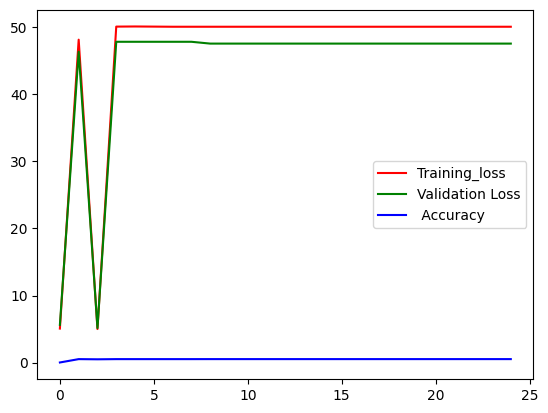

Test Accuracy of Model 0.01-25-0.9 is: 48.648648648648646%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-25-0.92 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-25-0.92 is finished, and it took 71.78149819374084 seconds.


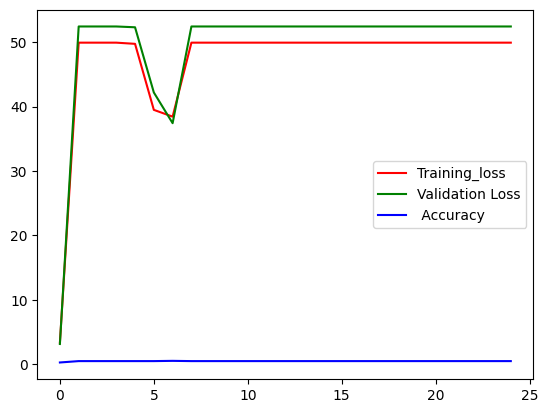

Test Accuracy of Model 0.01-25-0.92 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-25-0.94 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-25-0.94 is finished, and it took 41.37275719642639 seconds.


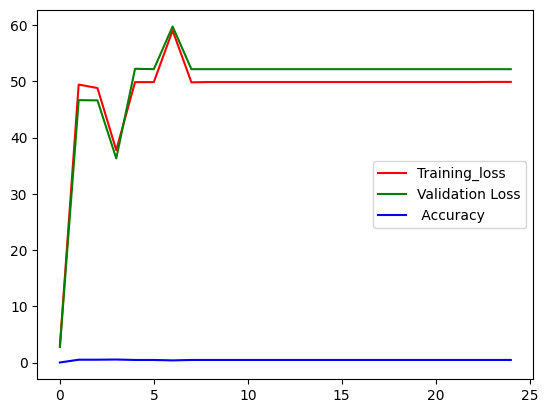

Test Accuracy of Model 0.01-25-0.94 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-25-0.96 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-25-0.96 is finished, and it took 43.017573595047 seconds.


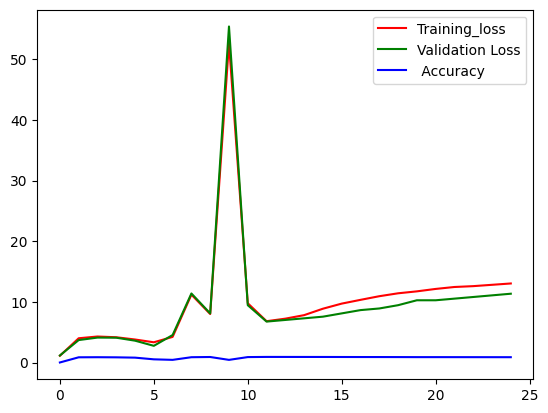

Test Accuracy of Model 0.01-25-0.96 is: 87.29729729729729%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-25-0.98 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-25-0.98 is finished, and it took 43.972607374191284 seconds.


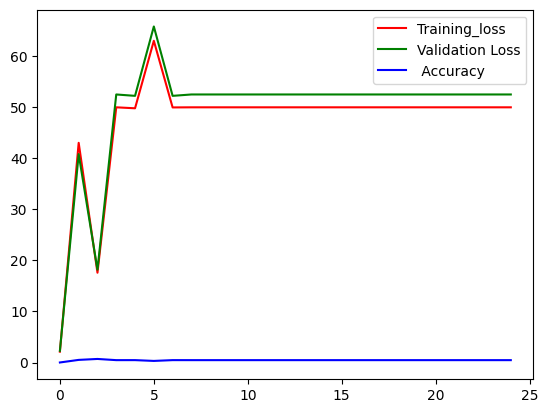

Test Accuracy of Model 0.01-25-0.98 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-30-0.9 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-30-0.9 is finished, and it took 60.249271869659424 seconds.


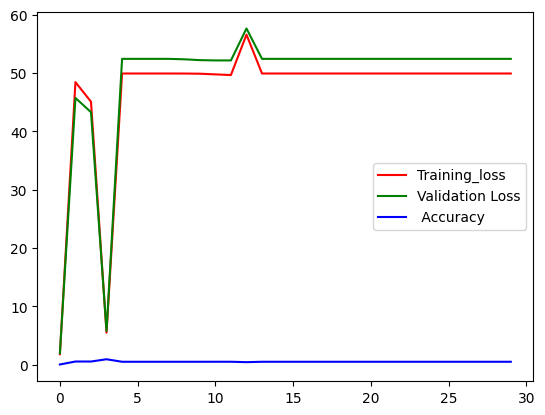

Test Accuracy of Model 0.01-30-0.9 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-30-0.92 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-30-0.92 is finished, and it took 61.29448366165161 seconds.


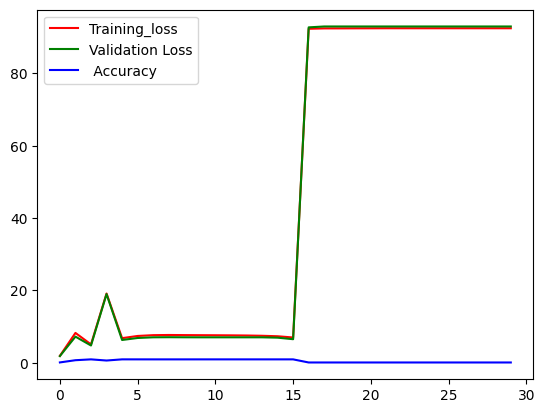

Test Accuracy of Model 0.01-30-0.92 is: 7.027027027027027%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-30-0.94 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-30-0.94 is finished, and it took 49.178171157836914 seconds.


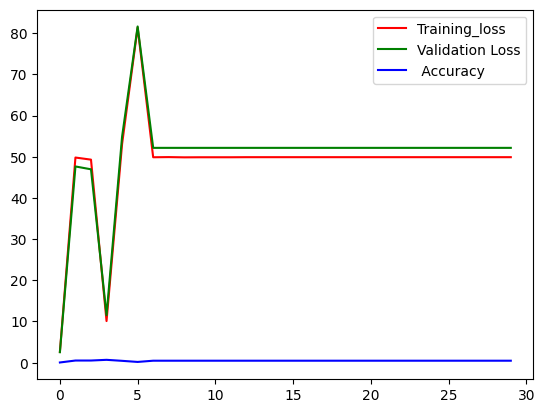

Test Accuracy of Model 0.01-30-0.94 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-30-0.96 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-30-0.96 is finished, and it took 50.37555193901062 seconds.


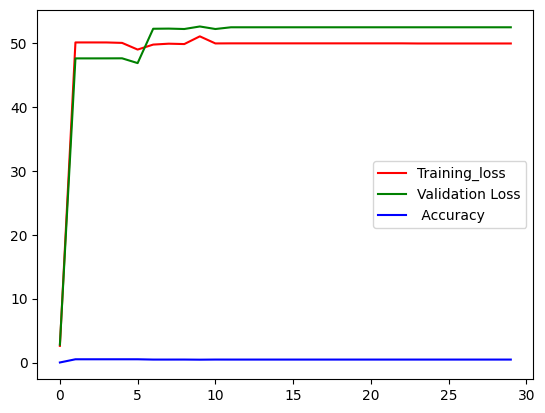

Test Accuracy of Model 0.01-30-0.96 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-30-0.98 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-30-0.98 is finished, and it took 49.11909890174866 seconds.


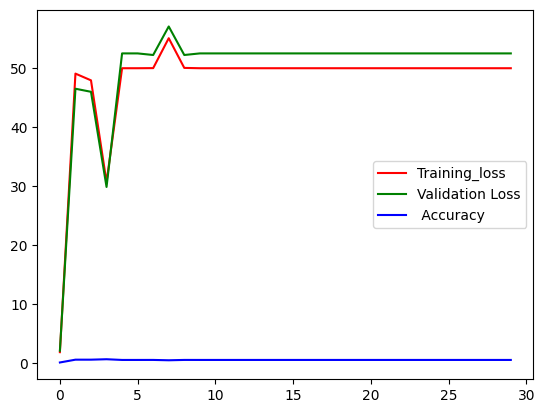

Test Accuracy of Model 0.01-30-0.98 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-35-0.9 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-35-0.9 is finished, and it took 69.17005896568298 seconds.


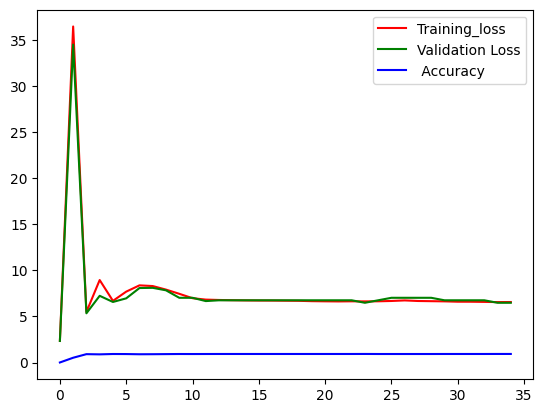

Test Accuracy of Model 0.01-35-0.9 is: 92.70270270270271%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-35-0.92 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-35-0.92 is finished, and it took 91.33149814605713 seconds.


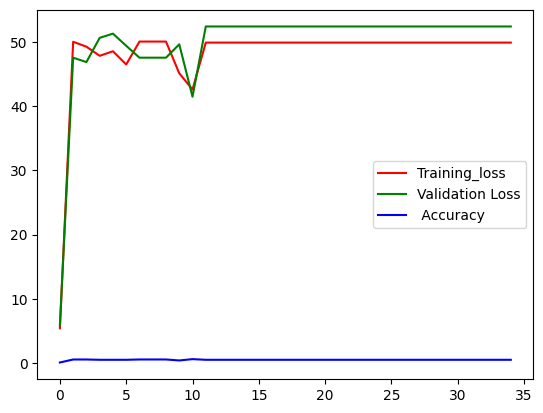

Test Accuracy of Model 0.01-35-0.92 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-35-0.94 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-35-0.94 is finished, and it took 57.33397364616394 seconds.


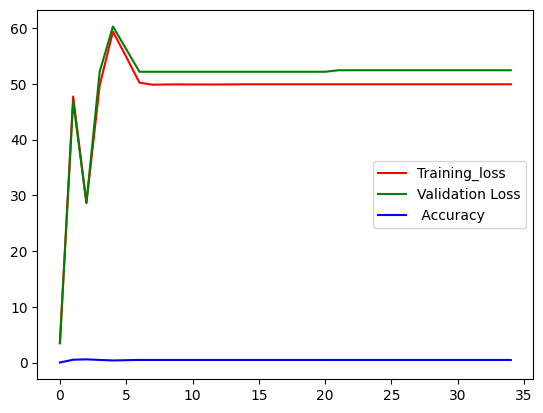

Test Accuracy of Model 0.01-35-0.94 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-35-0.96 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-35-0.96 is finished, and it took 60.53780198097229 seconds.


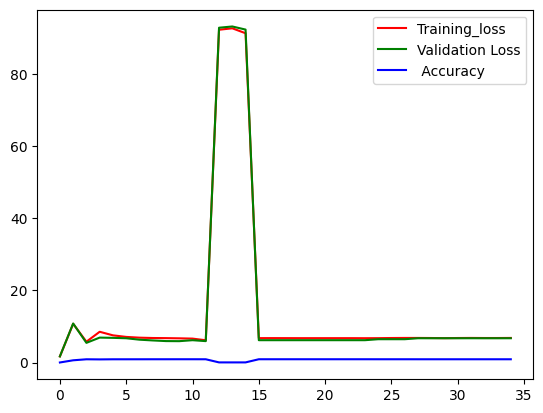

Test Accuracy of Model 0.01-35-0.96 is: 92.70270270270271%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-35-0.98 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-35-0.98 is finished, and it took 70.6014335155487 seconds.


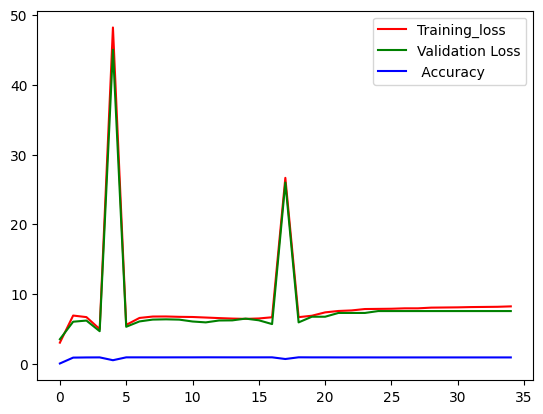

Test Accuracy of Model 0.01-35-0.98 is: 92.43243243243244%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-40-0.9 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-40-0.9 is finished, and it took 85.61495351791382 seconds.


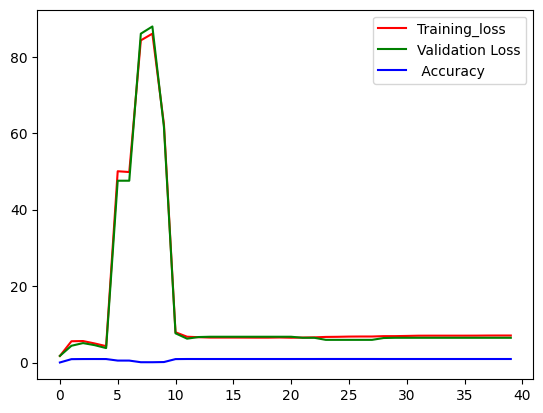

Test Accuracy of Model 0.01-40-0.9 is: 93.24324324324324%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-40-0.92 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-40-0.92 is finished, and it took 71.36420488357544 seconds.


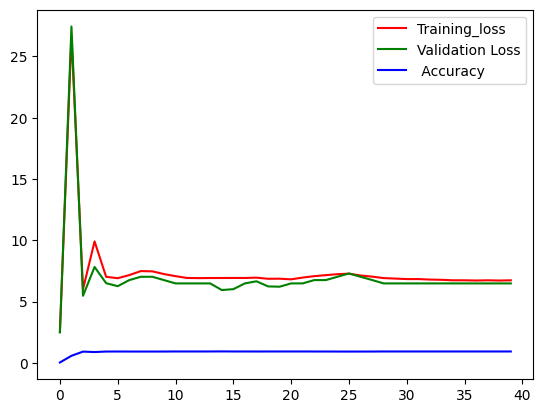

Test Accuracy of Model 0.01-40-0.92 is: 92.97297297297297%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-40-0.94 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-40-0.94 is finished, and it took 105.77168989181519 seconds.


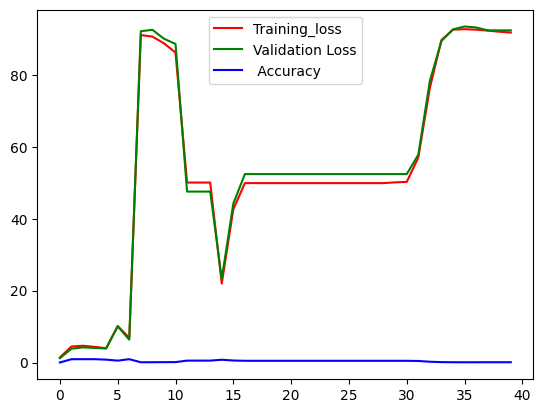

Test Accuracy of Model 0.01-40-0.94 is: 7.837837837837838%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-40-0.96 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-40-0.96 is finished, and it took 63.501468658447266 seconds.


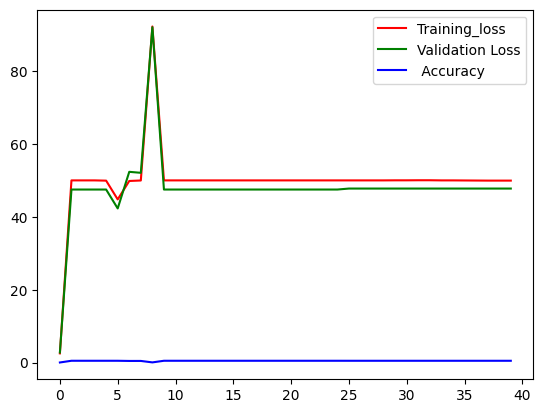

Test Accuracy of Model 0.01-40-0.96 is: 48.648648648648646%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-40-0.98 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-40-0.98 is finished, and it took 64.44915294647217 seconds.


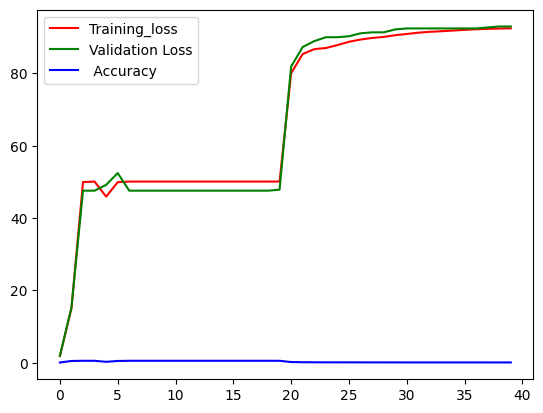

Test Accuracy of Model 0.01-40-0.98 is: 7.027027027027027%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-45-0.9 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-45-0.9 is finished, and it took 73.38987112045288 seconds.


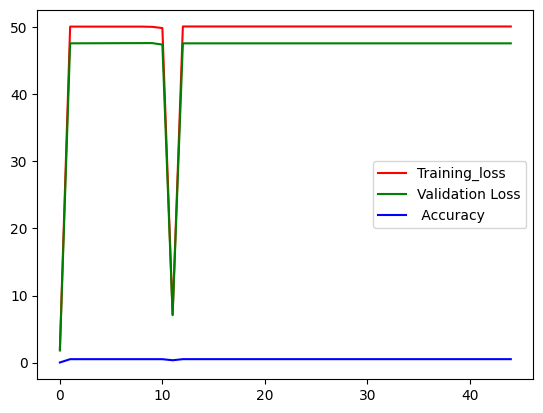

Test Accuracy of Model 0.01-45-0.9 is: 48.648648648648646%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-45-0.92 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-45-0.92 is finished, and it took 76.75048542022705 seconds.


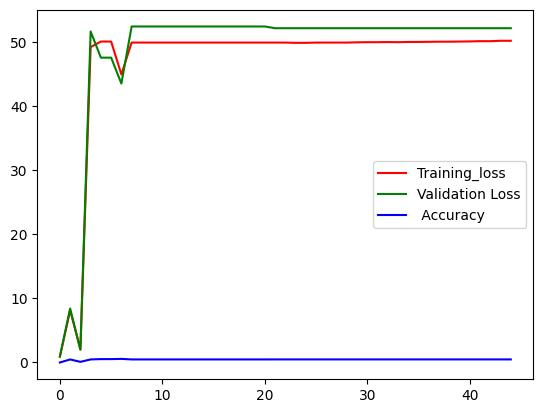

Test Accuracy of Model 0.01-45-0.92 is: 50.810810810810814%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-45-0.94 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-45-0.94 is finished, and it took 96.57265734672546 seconds.


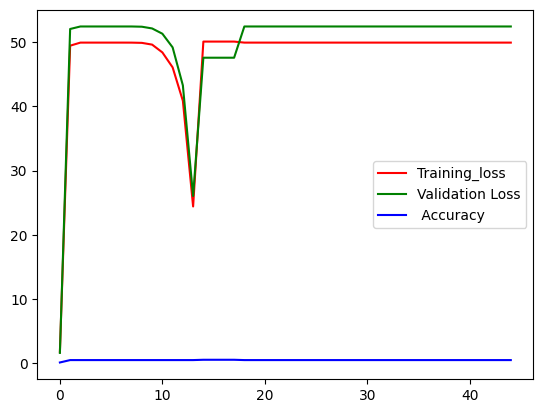

Test Accuracy of Model 0.01-45-0.94 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-45-0.96 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-45-0.96 is finished, and it took 83.24386715888977 seconds.


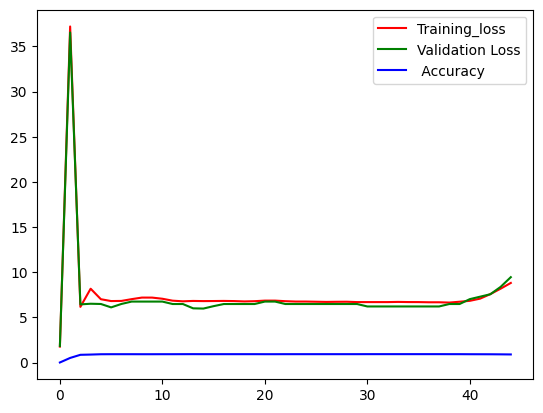

Test Accuracy of Model 0.01-45-0.96 is: 89.45945945945945%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-45-0.98 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-45-0.98 is finished, and it took 92.84109950065613 seconds.


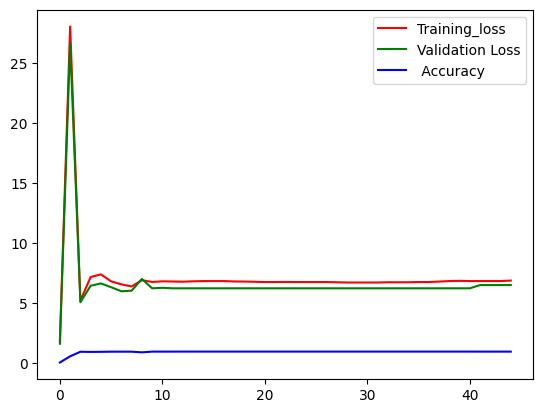

Test Accuracy of Model 0.01-45-0.98 is: 93.24324324324324%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-50-0.9 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-50-0.9 is finished, and it took 85.54052782058716 seconds.


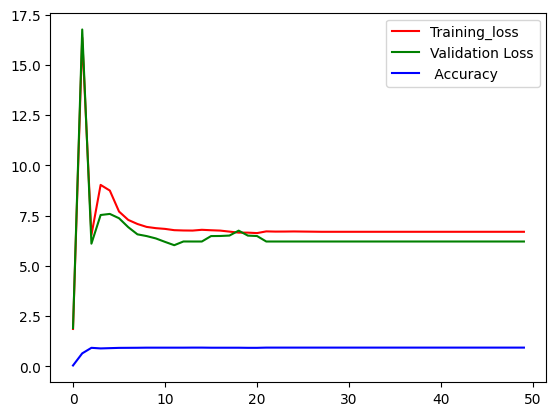

Test Accuracy of Model 0.01-50-0.9 is: 92.97297297297297%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-50-0.92 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-50-0.92 is finished, and it took 82.6342704296112 seconds.


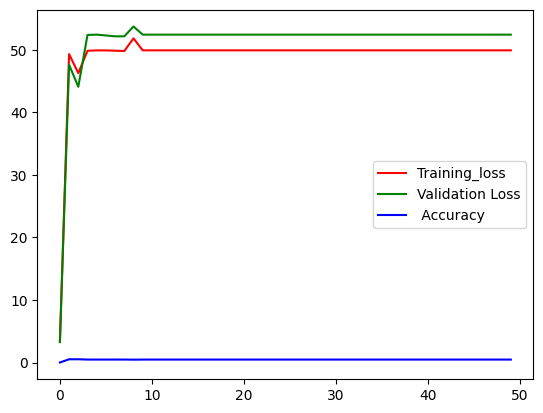

Test Accuracy of Model 0.01-50-0.92 is: 51.351351351351354%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-50-0.94 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-50-0.94 is finished, and it took 91.89221572875977 seconds.


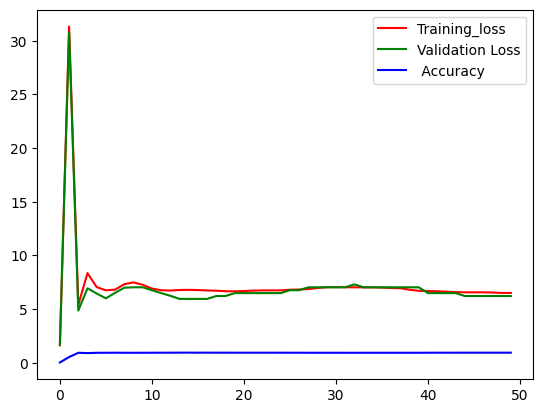

Test Accuracy of Model 0.01-50-0.94 is: 93.51351351351352%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-50-0.96 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


Training of 0.01-50-0.96 is finished, and it took 94.55772542953491 seconds.


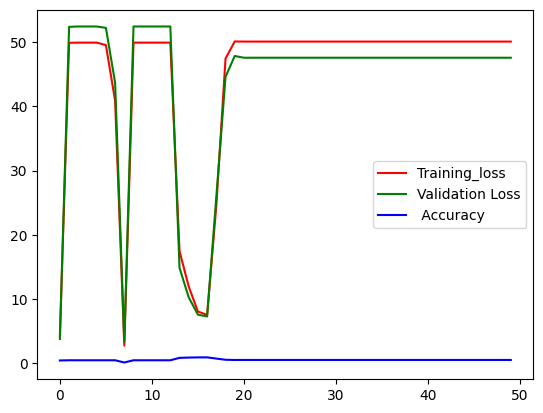

Test Accuracy of Model 0.01-50-0.96 is: 48.648648648648646%
Testing is done. Now we reset the parameters.
Parameters have been reseted. Model is ready to be retrained.
Training of 0.01-50-0.98 has started.


<ipython-input-14-1015bda322e7>:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df_training_loss,df_val_loss,df_accuracy],1).to_excel(writer, sheet_name = f'{lr}-{epochs}-{momentum}')


In [ ]:
learning_rates = [0.01]
epochs = [25,30,35,40,45,50]
momenta = [0.9,0.92,0.94,0.96,0.98]
# learning_rates=[0.001,0.01]
# epochs =[1]
# momenta = [0.9]
writer = pd.ExcelWriter('Results.xlsx', engine='xlsxwriter')
for lr in learning_rates:
  for epoch in epochs:
    for momentum in momenta:
      dir = create_dir(lr,epoch,momentum)
      a,b,c = training(lr, epoch, momentum, training_inputs, training_labels, val_inputs, val_labels, dir)
      testing (test_inputs, test_labels, lr, momentum, epoch,a,b,c, writer)
      print("Testing is done. Now we reset the parameters.")
      for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()
      print("Parameters have been reseted. Model is ready to be retrained.")

writer.save()
from google.colab import files
files.download('Results.xlsx') 
# workbook.save('/content/drive/MyDrive/Experimental Data')